In [1]:
import os
import sys
import numpy as np
import pandas as pd
import importlib
from shutil import rmtree, copy, copytree
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['DejaVu Serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.size'] = 30
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = True
rcParams['mathtext.default'] = 'regular'
rcParams['text.usetex'] = False

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from casatasks import listobs, split, clearcal, delmod, rmtables, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, fixvis, phaseshift, casalog, mstransform, exportfits
from casatools import componentlist, msmetadata, imager, ms, table

In [2]:
# Set path for measurement set, analysis output, and CASA log files
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-03-07/'
casalog.setlogfile(f'{basepath}/casa_logfile.log')

True

In [3]:
#for file in os.listdir(basepath):
#    if file.endswith('.ms'):
#        file_prefix = file.split('.ms')[0]
#        file_copy = f'{file_prefix}_base.ms'
#        os.system(f'scp -r {os.path.join(basepath, file)} {os.path.join(basepath, file_copy)}')
#        print(f'Made copy: {file_copy}')

In [4]:
# Identify the base measurement sets and sorted them in time
msfiles = [file for file in os.listdir(basepath) if file.endswith('_base.ms')]
msfiles_sorted = sorted(msfiles, key=lambda fname: float(fname.split("_ra")[1].split("_")[0]))
msfile = msfiles_sorted[3]

print('\n')
print(f'Base MS File: {msfile}')
print('\n')



Base MS File: 2025-03-07T01:59:28_ra076.8_dec+45.3_base.ms




In [5]:
# Identify the base measurement sets
#msfiles = [file for file in os.listdir(basepath) if file.endswith('base.ms')]
##msfiles = ['2025-02-18T04:12:28_ra093.5_dec+23.7_base.ms', '2025-02-18T04:17:37_ra094.7_dec+23.7_base.ms', '2025-02-18T04:22:46_ra096.0_dec+23.7_base.ms', '2025-02-18T04:27:56_ra097.3_dec+23.7_base.ms']
#msfile = msfiles[0]
#
#print('\n')
#print(f'Base MS File: {msfile}')
#print('\n')

#idx = 3
msdate = msfile.split('_')[0]
chanstoavg = 8
field_image_idx = 11
field_cal_idx0, field_cal_idx1 = 0, 23
uvrange = '1klambda'
refant = 'pad103'

print('\n')
print(f'Observation Date: {msdate}')
print(f'No. Channels to Average: {chanstoavg}')
print(f'Central Field: Field {field_image_idx}')
print(f'Fields to Calibrate Over: Field {field_cal_idx0} to Field {field_cal_idx1}')
print('\n')




Observation Date: 2025-03-07T01:59:28
No. Channels to Average: 8
Central Field: Field 11
Fields to Calibrate Over: Field 0 to Field 23




In [6]:
msfile_image = msfile.split(".ms")[0][:-5]+f'_image_sb{chanstoavg}.ms'
msfile_bcal = msfile.split(".ms")[0][:-5]+f'_bcal_sb{chanstoavg}.ms'
msmd = msmetadata()
msmd.open(os.path.join(basepath, msfile))
fieldnames = msmd.fieldnames()

fieldname_image = fieldnames[field_image_idx]
fieldname_cal_list = fieldnames[field_cal_idx0: field_cal_idx1]
fieldname_cal = ', '.join(fieldname_cal_list)

print(f'Field Name (Image): {fieldname_image}')
print(f'Field Names (Calibration): {fieldname_cal}')
print('\n')

Field Name (Image): drift_ra5h07m04s
Field Names (Calibration): drift_ra5h04m42s, drift_ra5h04m55s, drift_ra5h05m08s, drift_ra5h05m21s, drift_ra5h05m34s, drift_ra5h05m47s, drift_ra5h06m00s, drift_ra5h06m13s, drift_ra5h06m26s, drift_ra5h06m39s, drift_ra5h06m52s, drift_ra5h07m04s, drift_ra5h07m17s, drift_ra5h07m30s, drift_ra5h07m43s, drift_ra5h07m56s, drift_ra5h08m09s, drift_ra5h08m22s, drift_ra5h08m35s, drift_ra5h08m48s, drift_ra5h09m01s, drift_ra5h09m14s, drift_ra5h09m27s




In [42]:
print(f'Imaging MS File: {msfile_image}')
print('\n')

if os.path.exists(os.path.join(basepath, msfile_image)):
    rmtree(os.path.join(basepath, msfile_image))
    #copytree(os.path.join(basepath, msfile_image), os.path.join(basepath, msfile_image))
split(vis=os.path.join(basepath, msfile), outputvis=os.path.join(basepath, msfile_image), datacolumn='all', width=chanstoavg)

print(f'MS File to rephase to bandpass calibrator: {msfile_bcal}')
print('\n')

if os.path.exists(os.path.join(basepath, msfile_bcal)):
    rmtree(os.path.join(basepath, msfile_bcal))
    #copytree(os.path.join(basepath, msfile_image), os.path.join(basepath, msfile_bcal))
split(vis=os.path.join(basepath, msfile), outputvis=os.path.join(basepath, msfile_bcal), datacolumn='all', width=chanstoavg)

Imaging MS File: 2025-03-07T01:59:28_ra076.8_dec+45.3_image_sb8.ms


MS File to rephase to bandpass calibrator: 2025-03-07T01:59:28_ra076.8_dec+45.3_bcal_sb8.ms




In [7]:
print('Reset base MS...')
print('\n')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile)+'.flagversions')
print('\n')

print('Reset imaging MS...')
print('\n')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile_image))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile_image))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile_image) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile_image), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile_image)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile_image)+'.flagversions')
print('\n')

print('Reset bcal MS...')
print('\n')
print('Clear any old MODEL_DATA, CORRECTED_DATA, etc...')
clearcal(vis=os.path.join(basepath, msfile_bcal))
print('Delete Sky Model')
delmod(vis=os.path.join(basepath, msfile_bcal))
print('Removing Residual Tables')
for ext in ['.image','.mask','.model','.image.pbcor','.psf','.residual','.pb','.sumwt']:
    rmtables(os.path.join(basepath, msfile_bcal) + ext)
print('Removing Flags')
flagdata(vis=os.path.join(basepath, msfile_bcal), mode='unflag', flagbackup=False)
if os.path.exists(os.path.join(basepath, msfile_bcal)+'.flagversions'):
    rmtree(os.path.join(basepath, msfile_bcal)+'.flagversions')
print('\n')

Reset base MS...


Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-18 18:56:18	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags


Reset imaging MS...


Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-18 18:56:34	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags


Reset bcal MS...


Clear any old MODEL_DATA, CORRECTED_DATA, etc...


2025-03-18 18:56:38	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Delete Sky Model
Removing Residual Tables
Removing Flags




In [ ]:
fieldtoflag = fieldname_cal

print('Flagging Data for RFI in imaging MS...')
print('\n')
tfcrop_pars = {'timecutoff':3, 'freqcutoff':3, 'maxnpieces':1, 'growfreq':25, 'combinescans':True, 'ntime':'300s'}
flagdata(vis=os.path.join(basepath, msfile_image), field=fieldtoflag, mode='tfcrop', datacolumn='data', action='apply', flagbackup=False, **tfcrop_pars)

print('Flagging Data for RFI in calibration MS...')
print('\n')
tfcrop_pars = {'timecutoff':3, 'freqcutoff':3, 'maxnpieces':1, 'growfreq':25, 'combinescans':True, 'ntime':'300s'}
flagdata(vis=os.path.join(basepath, msfile_bcal), field=fieldtoflag, mode='tfcrop', datacolumn='data', action='apply', flagbackup=False, **tfcrop_pars)


Flagging Data for RFI in imaging MS...




Flagging Data for RFI in calibration MS...




{}

Producing RFI flagging diagnostic plot...


RFI flagging diagnostic plot saved!


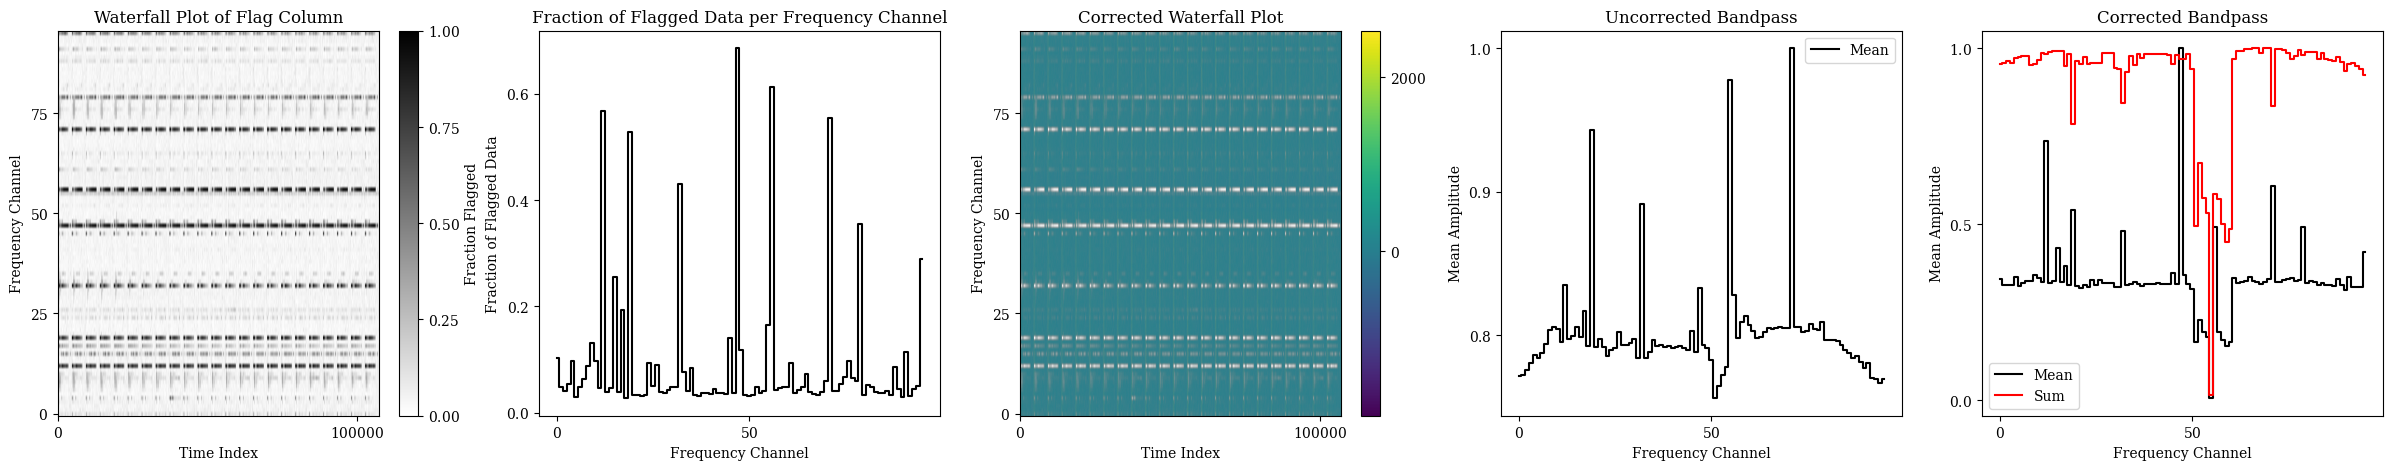

In [15]:
# Open the measurement set
print('Producing RFI flagging diagnostic plot...')
print('\n')
ms_tool = ms()
ms_tool.open(os.path.join(basepath, msfile_bcal))
ms_tool.msselect({'field':fieldname_cal})
# Retrieve the data and flag columns
data = ms_tool.getdata(['data', 'flag'])
flags = data['flag'] # boolean flags
vis = data['data'] # complex visibilities
ms_tool.close()

# If there are multiple polarizations, average them to get a fraction flagged.
# Note: flags are boolean, so averaging converts them to a fractional value.
if flags.shape[0] > 1:
    flag_avg = np.mean(flags, axis=0)
else:
    flag_avg = flags[0]

# Compute the amplitude of the visibilities.
amp = np.abs(vis)  # shape: (npol, nchan, nrow)

# If there are multiple polarizations, combine them.
if amp.shape[0] > 1:
    # For flags, consider a sample flagged if any polarization is flagged.
    flag_mask = np.any(flags, axis=0)  # shape: (nchan, nrow)
    # Average the amplitude over polarizations.
    amp_avg = np.mean(amp, axis=0)       # shape: (nchan, nrow)
else:
    amp_avg = amp[0]
    flag_mask = flags[0]

# Create a masked array that masks out flagged samples.
masked_amp = np.ma.array(amp_avg, mask=flag_mask, fill_value=np.nan)
# Now, compute the bandpass by averaging over time (axis=1) for each frequency channel,
# ignoring the masked (flagged) samples.
bandpass_arr_mean = np.mean(masked_amp, axis=1)
bandpass_arr_sum = np.sum(masked_amp, axis=1) #/np.max(bandpass_arr)
bandpass_uncorr_mean = np.mean(amp_avg, axis=1)
bandpass_uncorr_sum = np.sum(amp_avg, axis=1) #/np.max(bandpass_uncorr)

# Waterfall Plot

# Set new fontsize
rcParams['font.size'] = 10

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5,
                                    figsize=(30, 5))
im = ax0.imshow(flag_avg, aspect='auto', origin='lower', cmap='binary')
ax0.set_xlabel('Time Index')
ax0.set_ylabel('Frequency Channel')
ax0.set_title('Waterfall Plot of Flag Column')
plt.colorbar(im, ax=ax0, label='Fraction Flagged')

# Fraction of flagged data per frequency channel (averaged over time)
flag_fraction = np.mean(flag_avg, axis=1)
ax1.plot(flag_fraction, drawstyle='steps-mid', c='k')
ax1.set_xlabel('Frequency Channel')
ax1.set_ylabel('Fraction of Flagged Data')
#ax1.set_xlim(350, 400)
ax1.set_title('Fraction of Flagged Data per Frequency Channel')

amp_mean = np.nanmean(masked_amp)
amp_std = np.nanstd(masked_amp)
im = ax2.imshow(masked_amp, vmin=amp_mean-1*amp_std, vmax=amp_mean+1*amp_std, aspect='auto', origin='lower')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Frequency Channel')
ax2.set_title('Corrected Waterfall Plot')
plt.colorbar(im, ax=ax2)

# Plot the corrected bandpass
ax3.plot(bandpass_uncorr_mean/np.max(bandpass_uncorr_mean), drawstyle='steps-mid', c='k', label='Mean')
#ax3.plot(bandpass_uncorr_sum/np.max(bandpass_uncorr_sum), drawstyle='steps-mid', c='r', label='Sum')
ax3.set_xlabel('Frequency Channel')
ax3.set_ylabel('Mean Amplitude')
#ax2.set_xlim(350, 400)
ax3.set_title('Uncorrected Bandpass')
ax3.legend()

# Plot the corrected bandpass
ax4.plot(bandpass_arr_mean/np.max(bandpass_arr_mean), drawstyle='steps-mid', c='k', label='Mean')
ax4.plot(bandpass_arr_sum/np.max(bandpass_arr_sum), drawstyle='steps-mid', c='r', label='Sum')
ax4.set_xlabel('Frequency Channel')
ax4.set_ylabel('Mean Amplitude')
#ax2.set_xlim(350, 400)
ax4.set_title('Corrected Bandpass')
ax4.legend()

fig.savefig(os.path.join(basepath, f'{msfile_bcal.split(".ms")[0]}_RFI_diagnostic_f{field_cal_idx0}f{field_cal_idx1}.pdf'))
print('RFI flagging diagnostic plot saved!')

# Revert fontsize
rcParams['font.size'] = 30

In [30]:
print('Finding a bandpass calibrator in the field...')
print('\n')

while True:
    try:
        sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
        import find_calibrators
        importlib.reload(find_calibrators)
        from find_calibrators import find_calibrator

        calibrator_name, calibrator_coord_hms, calibrator_coord_deg, flux_nvss = find_calibrator(basepath, msfile_bcal, fieldname=fieldname_image, top_n=1, pbfrac=0.25)
        print('________________________________________________________________________________________')
        print(f'Calibrator: {calibrator_name}')
        print(f'Calibrator Coordinates (hms): {calibrator_coord_hms}')
        print(f'Calibrator Coordinates (deg): {calibrator_coord_deg}')
        print(f'Calibrator Flux: {flux_nvss} Jy')
        break
    except Exception as e:
        print(f"An error occurred: {e}")

while True:
    try:
        sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
        import make_skymodel_cl_mf
        importlib.reload(make_skymodel_cl_mf)
        from make_skymodel_cl_mf import make_skymodel

        # Number of bright sources to include in the sky model
        top_n = 200

        print(f'Generating a sky model with the top {top_n} brightest NVSS sources...')

        # Define filename strings
        ra_str = f"{msfile.split('_')[1][2:5]}p{msfile.split('_')[1][6:9]}"
        dec_str = f"{msfile.split('_')[2][4:6]}p{msfile.split('_')[2][7:8]}"
        clfile = f'nvss_top{top_n}_{ra_str}_{dec_str}.cl'
        cllabel = clfile.split('.')[0]

        if os.path.exists(os.path.join(basepath, f'nvss_top{top_n}_{ra_str}_{dec_str}.cl')):
            rmtree(os.path.join(basepath, f'nvss_top{top_n}_{ra_str}_{dec_str}.cl'))

        nvss_catalog = make_skymodel(basepath, msfile_bcal, fieldname=fieldname_image, top_n=top_n, pbfrac=0.5)
        break
    except Exception as e:
        print(f"Server disconnected, trying again!")

Finding a bandpass calibrator in the field...



Including Primary Beam FWHM (2.946 degrees):
  RA:  74.741288 to 76.214113
  Dec: 44.533509 to 46.006334
Querying VIII/65/nvss ...
     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
045930+455248 04 59 30.78 +45 52 48.0      0.04 ...         <    17.0          
Querying J/A+A/598/A78/table3 ...
No matching TGSS sources.
Calibrator Name: J0459+4552
Coord (deg): 74.87824999999998, 45.88
Coord (hms): J2000 04h59m30.78s +45d52m48.0s
Flux (Jy): 0.426
Maj Axis: 17.7arcsec
Min Axis: 17.0arcsec
PA: 0.0deg
Spectral Index: None
________________________________________________________________________________________
Calibrator: J0459+4552
Calibrator Coordinates (hms): J2000 04h59m30.78s +45d52m48.0s
Calibrator Coordinates (deg): (74.87824999999998, 45.88)
Calibra

2025-03-18 03:16:50	WARN	componentlist::close	componentlist closed


Imaging the sky model and saving plot...
Image Parameters
----------------
nx, ny: (4800, 4800)
cellx, celly: ('3arcsec', '3arcsec')
mode: mfs
Phase Center: J2000 5h2m1.103883547434421s 45d16m11.94994553683216s
MS Selected: /data/jfaber/dsa110-contimg/sandbox/2025-03-07/2025-03-07T01:54:18_ra075.5_dec+45.3_bcal_sb8.ms


2025-03-18 03:16:59	WARN	imager::setdata()	Ignoring that ms/data/jfaber/dsa110-contimg/sandbox/2025-03-07/2025-03-07T01:54:18_ra075.5_dec+45.3_bcal_sb8.msspecified here
2025-03-18 03:16:59	WARN	imager::setdata()	Imager was constructed with an ms 
2025-03-18 03:16:59	WARN	imager::setdata()	if multi-ms are to be used please construct imager without parameters and use setdata to specify the ms's and selection


Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Phase center of the total field: J2000 5h2m1.103883547434421s 45d16m11.94994553683216s
Image Shape: (4800, 4800)


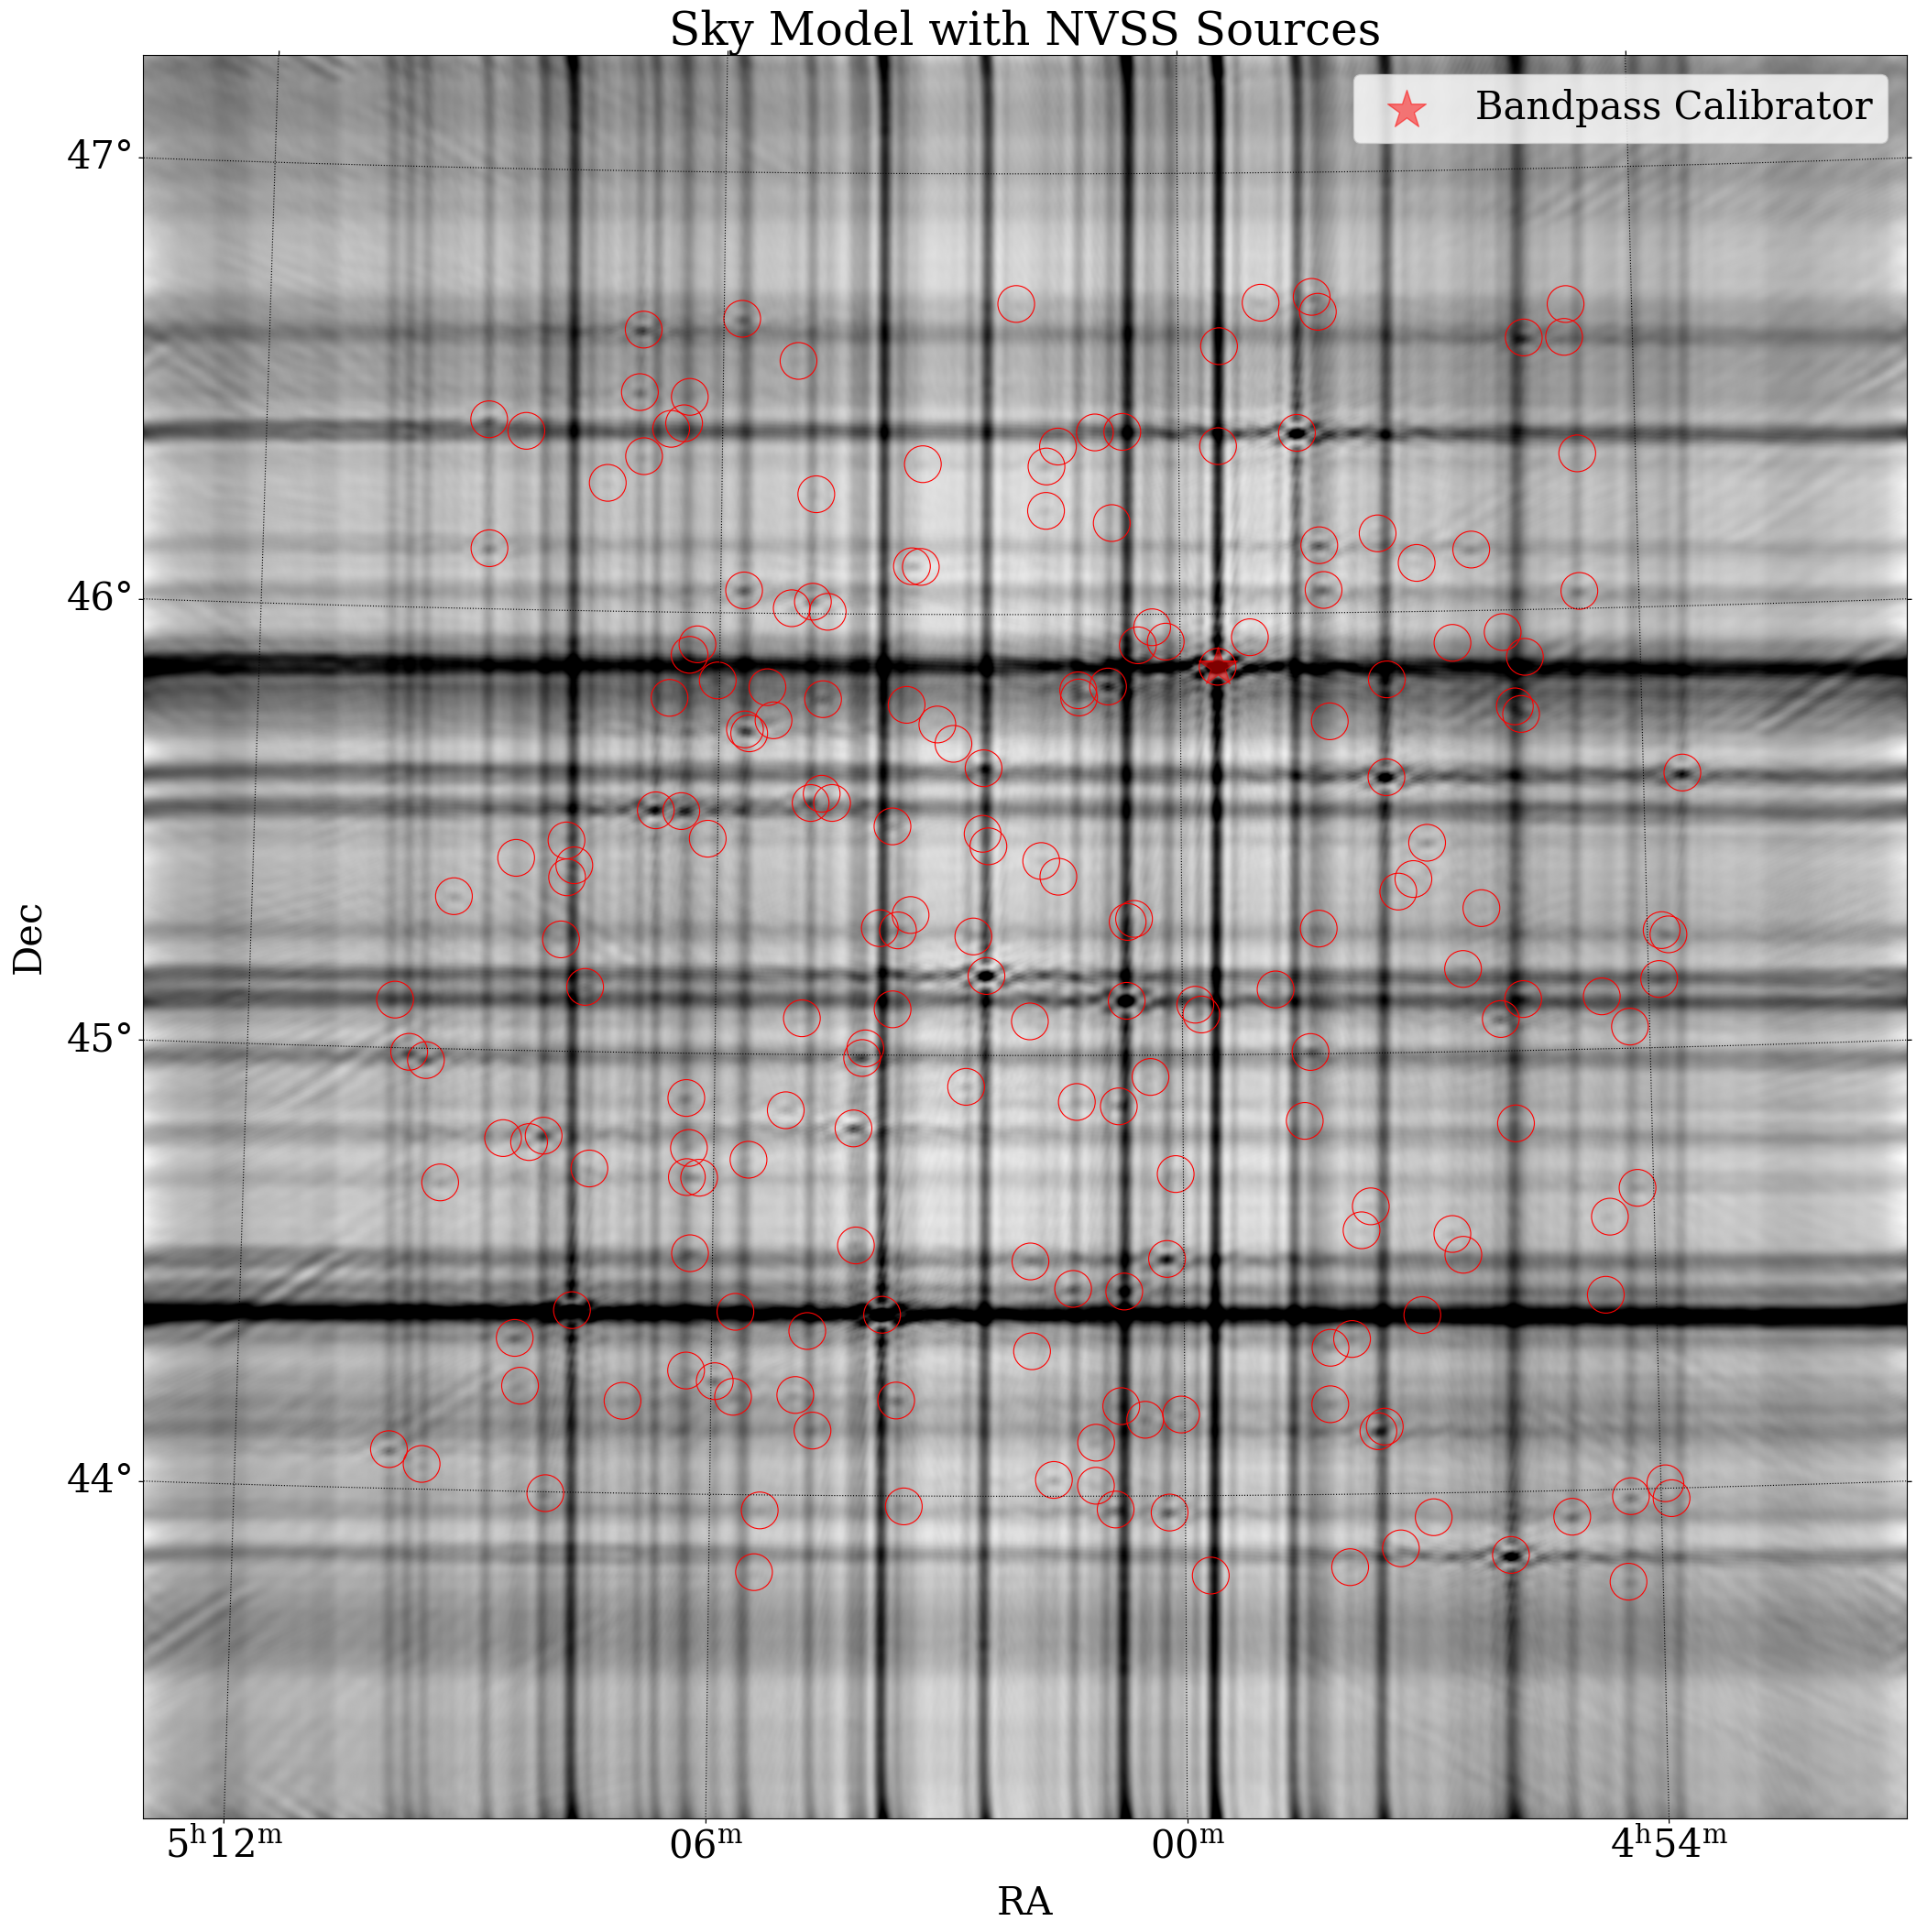

In [31]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import image_skymodel_cl
importlib.reload(image_skymodel_cl)
from image_skymodel_cl import image_skymodel

print('Imaging the sky model and saving plot...')

wcs_2d_coords_x, wcs_2d_coords_y, phasecenter = image_skymodel(basepath, msfile_bcal, fieldname_image, nvss_catalog, top_n=top_n, nx=4800, ny=4800, cellx='3arcsec', celly='3arcsec', mode='mfs', phasecenter=None)

print(f'Phase center of the total field: {phasecenter}')

# Load the FITS image
fitsfile = cllabel + '.image.fits'
fits_file = os.path.join(basepath, fitsfile)
hdu = fits.open(fits_file)[0]
print(f'Image Shape: {hdu.data[0, 0, :, :].shape}')
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (25, 25))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

cal_ra_deg, cal_dec_deg = calibrator_coord_deg
cal_coord_x, cal_coord_y = wcs_2d.world_to_pixel_values(cal_ra_deg, cal_dec_deg)
ax.scatter(cal_coord_x, cal_coord_y, marker='*', s=1000, c='red', alpha=0.5, label = 'Bandpass Calibrator')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.legend()

# Show the plot
plt.title('Sky Model with NVSS Sources')
plt.grid(color='k', ls='dotted')
fig.savefig(os.path.join(basepath, f'{cllabel}_image.pdf'))

In [ ]:
print(f'Copy the MS and place the phasecenter on the {calibrator_name}...')

msfile_bcal_cntrd = msfile_bcal.split(".ms")[0]+f'_cntrd.ms'

#channelstoavg=16
if os.path.exists(os.path.join(basepath, msfile_bcal_cntrd)):
    rmtree(os.path.join(basepath, msfile_bcal_cntrd))
    rmtree(os.path.join(basepath, msfile_bcal_cntrd.split(".ms")[0]+'.flagversions'))

mstransform(vis=os.path.join(basepath, msfile_bcal), outputvis=os.path.join(basepath, msfile_bcal_cntrd), phasecenter=calibrator_coord_hms)

Copy the MS and place the phasecenter on the J0459+4552...


In [ ]:
print('Placing the sky model in the MODEL column of the centered and non-centered MS...')
print('\n')

#for fieldname in field_names:      
ft(vis=os.path.join(basepath, msfile_bcal_cntrd), 
    field=fieldname_cal,
    complist=os.path.join(basepath, clfile), 
    reffreq='1.4GHz',
    usescratch=True)

ft(vis=os.path.join(basepath, msfile_bcal), 
    field=fieldname_cal,
    complist=os.path.join(basepath, clfile), 
    reffreq='1.4GHz',
    usescratch=True)

Placing the sky model in the MODEL column of the centered and non-centered MS...




In [33]:
print('Setting bandpass solution table names...')
print('\n')

os.chdir(basepath)

#bcalfield = fieldname
bcalfield = fieldname_cal

if bcalfield is None:
    bcalfile = f'{calibrator_name}_{msdate}_allfields.bcal'

else:
    bcalfile = f'{calibrator_name}_{msdate}_f{field_cal_idx0}f{field_cal_idx1}.bcal'

Setting bandpass solution table names...




In [ ]:
print('Performing bandpass calibration...')
print('\n')

if os.path.exists(os.path.join(basepath, bcalfile)):
    rmtree(os.path.join(basepath, bcalfile))

if bcalfield is None:

    bandpass(vis=os.path.join(basepath, msfile_bcal_cntrd),
            field='',
            caltable=os.path.join(basepath, bcalfile),
            refant=refant,
            solint='inf',
            bandtype='B',
            combine='scan, obs, field',
            uvrange='>' + uvrange)

else:

    bandpass(vis=os.path.join(basepath, msfile_bcal_cntrd),
            field=bcalfield,
            caltable=os.path.join(basepath, bcalfile),
            refant=refant,
            solint='inf',
            bandtype='B',
            combine='scan, obs, field',
            uvrange='>' + uvrange)

Performing bandpass calibration...


15 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=95) at 2025/03/07/01:51:31.4
15 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=94) at 2025/03/07/01:51:31.4
13 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=93) at 2025/03/07/01:51:31.4
14 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=92) at 2025/03/07/01:51:31.4
15 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=91) at 2025/03/07/01:51:31.4
14 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=90) at 2025/03/07/01:51:31.4
13 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=89) at 2025/03/07/01:51:31.4
13 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=88) at 2025/03/07/01:51:31.4
14 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=87) at 2025/03/07/01:51:31.4
13 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=86) at 2025/03/07/01:51:31.4
13 of 192 solutions flagged due to SNR < 3 in spw=0 (chan=85) at 2025/03/07/01:51:31.4
14 of 

In [ ]:
print('Checking for bad antennas so we know which to flag before imaging...')
print('\n')

sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import check_ants
importlib.reload(check_ants)
from check_ants import compute_antenna_quality

# Run the improved quality check on the calibration table
#cal_table = os.path.join(basepath, bcalfile)
ant_stats, bad_antennas = compute_antenna_quality(os.path.join(basepath, bcalfile))
#print(f"\nIdentified {len(bad_antennas)} bad antennas: {bad_antennas}")
ant_add_pad = ['pad' + str(i+1) for i in bad_antennas]
ant_names = ', '.join(ant_add_pad)
print(f'\nIdentified {len(bad_antennas)} bad antennas: {ant_names}')

Checking for bad antennas so we know which to flag before imaging...


Antenna Quality Summary:
   Antenna         Med Amp        MAD(amp)      n_sol      Valid(amp) |       Med Phase      MAD(phase)      n_sol    Valid(phase)   Amp Dev (MAD)
------------------------------------------------------------------------------------------------------------------------
         0          1.3417          0.0455         96            1.00 |       -257.4138        127.0332         96            1.00            0.80
         1          1.4145          0.0367         96            1.00 |        -24.3119         53.8102         96            1.00            1.14
         2          1.2862          0.0284         96            0.99 |       -111.8866         46.4810         96            1.00            0.54
         3          1.2195          0.0481         96            1.00 |       -166.6771         68.6330         96            1.00            0.22
         4          1.1310          0.0362      

In [ ]:
print('Applying bandpass solutions to centered and non-centered MS...')
print('\n')

applycal(vis=os.path.join(basepath, msfile_bcal_cntrd),
        field=fieldname_cal,
        gaintable=os.path.join(basepath, bcalfile))

applycal(vis=os.path.join(basepath, msfile_bcal),
        field=fieldname_cal,
        gaintable=os.path.join(basepath, bcalfile))


Applying bandpass solutions to centered and non-centered MS...




In [ ]:
print('Flagging antennas based on bandpass solutions, autocorrelating, shadowing, clipping, on centered and non-centered MS...')
print('\n')

flagdata(vis=os.path.join(basepath, msfile_image), mode='manual', antenna=ant_names)
flagdata(vis=os.path.join(basepath, msfile_image), mode='manual', autocorr=True, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_image), mode='shadow', tolerance=0.0, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_image), mode='clip', clipzeros=True, flagbackup=False)

flagdata(vis=os.path.join(basepath, msfile_bcal_cntrd), mode='manual', antenna=ant_names)
flagdata(vis=os.path.join(basepath, msfile_bcal_cntrd), mode='manual', autocorr=True, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_bcal_cntrd), mode='shadow', tolerance=0.0, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_bcal_cntrd), mode='clip', clipzeros=True, flagbackup=False)

flagdata(vis=os.path.join(basepath, msfile_bcal), mode='manual', antenna=ant_names)
flagdata(vis=os.path.join(basepath, msfile_bcal), mode='manual', autocorr=True, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_bcal), mode='shadow', tolerance=0.0, flagbackup=False)
flagdata(vis=os.path.join(basepath, msfile_bcal), mode='clip', clipzeros=True, flagbackup=False)

Flagging antennas based on bandpass solutions, autocorrelating, shadowing, clipping, on centered and non-centered MS...




2025-03-14 00:08:13	WARN	FlagDataHandler::preLoadColumn (file /source/casa6/casatools/src/code/flagging/Flagging/FlagDataHandler.cc, line 989)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.
2025-03-14 00:08:18	WARN	FlagDataHandler::preLoadColumn (file /source/casa6/casatools/src/code/flagging/Flagging/FlagDataHandler.cc, line 989)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.
2025-03-14 00:08:23	WARN	FlagDataHandler::preLoadColumn (file /source/casa6/casatools/src/code/flagging/Flagging/FlagDataHandler.cc, line 989)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.


{}

In [ ]:
#print('Performing phase calibration...')
#print('\n')
#
##bcalfield = fieldname
#pcalfield = fieldname_cal
#
#if pcalfield is None:
#    pcalfile = f'{calibrator_name}_{msdate}_allfields.pcal'
#else:
#    pcalfile = f'{calibrator_name}_{msdate}_f{field_cal_idx0}f{field_cal_idx1}.pcal'
#
#if os.path.exists(os.path.join(basepath, pcalfile)):
#    rmtree(os.path.join(basepath, pcalfile))
#
#if pcalfield is None:
#
#    gaincal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#            field='',
#            caltable=os.path.join(basepath, pcalfile),
#            refant=refant,
#            solint='inf',
#            calmode='p',
#            gaintype='K',
#            #gaintable = ['J1132+1628_2025-03-02T08:43:06_f0f23.bcal'],
#            combine='scan, obs, field',
#            uvrange='>'+uvrange)
#
#else:
#
#    gaincal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#            field=pcalfield,
#            caltable=os.path.join(basepath, pcalfile),
#            refant=refant,
#            solint='inf',
#            calmode='p',
#            gaintype='K',
#            #gaintable = ['J1132+1628_2025-03-02T08:43:06_f0f23.bcal'],
#            combine='scan, obs, field',
#            uvrange='>'+uvrange)

In [ ]:
#print('Applying phase solutions to centered and non-centered MS...')
#print('\n')
#
#applycal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#        field=fieldname_cal,
#        gaintable=os.path.join(basepath, pcalfile))
#
#applycal(vis=os.path.join(basepath, msfile_bcal),
#        field=fieldname_cal,
#        gaintable=os.path.join(basepath, pcalfile))

In [ ]:
#print('Performing amplitude calibration...')
#print('\n')
#
##bcalfield = fieldname
#acalfield = fieldname_cal
#
#if acalfield is None:
#    acalfile = f'{calibrator_name}_{ra_str}_{dec_str}_allfields.acal'
#else:
#    acalfile = f'{calibrator_name}_{ra_str}_{dec_str}_f{field_cal_idx0}f{field_cal_idx1}.acal'
#
#if acalfield is None:
#
#    gaincal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#            field='',
#            caltable=os.path.join(basepath, acalfile),
#            refant='pad103',
#            solint='inf',
#            calmode='a',
#            gaintype='G',
#            combine='scan, obs, field',
#            uvrange='>0.3klambda')
#
#else:
#
#    gaincal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#            field=acalfield,
#            caltable=os.path.join(basepath, acalfile),
#            refant='pad103',
#            solint='inf',
#            calmode='a',
#            gaintype='G',
#            combine='scan, obs, field',
#            uvrange='>0.3klambda')

In [ ]:
#print('Applying amplitude solutions to centered and non-centered MS...')
#print('\n')
#
#applycal(vis=os.path.join(basepath, msfile_bcal_cntrd),
#        field=fieldname_cal,
#        gaintable=os.path.join(basepath, acalfile))
#
#applycal(vis=os.path.join(basepath, msfile_bcal),
#        field=fieldname_cal,
#        gaintable=os.path.join(basepath, acalfile))
#

In [ ]:
print('\n')
print('Imaging with tclean...')
print('\n')

os.chdir(basepath)

imsize_x, imsize_y = 4800, 4800
cell_res = '3arcsec'
weighttype = 'uniform'
niter = 10000
weight = 0.5
uvrange = '1klambda'
imagetype = 'clean'
imageparams = f'{imagetype}_{weighttype}{weight}_uv{uvrange}_{imsize_x}x{cell_res[:4]}_nitr{niter}'
imagename = f'{msfile_bcal.split(".ms")[0]}_f{field_cal_idx0}f{field_cal_idx1}_{imageparams}'
tclean(vis=os.path.join(basepath, msfile_bcal),
    field=fieldname_cal,            
    imagename=os.path.join(basepath, imagename),
    specmode='mfs',
    deconvolver='hogbom',
    gridder='wproject',
    wprojplanes=-1,  # auto (if using wproject)
    niter=niter,             
    threshold='0.0001Jy',
    interactive=False,
    imsize=[imsize_x, imsize_y],
    cell=[cell_res], 
    weighting=weighttype,
    robust=weight,
    pblimit=0.25,
    psfcutoff=0.5,
    uvrange='>'+uvrange,
    phasecenter=phasecenter,
    savemodel='modelcolumn')



Imaging with tclean...





0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 10000,
 'cyclethreshold': 0.0015293884789571166,
 'interactiveiterdone': 11391,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 11391,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.3847619295120239,
 'minpsffraction': 0.05000000074505806,
 'niter': 10000,
 'nmajordone': 6,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([    0,    38,   175,   763,  3391, 11391]),
 'summaryminor': {0: {0: {0: {'iterDone': [38.0, 137.0, 588.0, 2628.0, 8000.0],
     'peakRes': [0.12385783344507217,
      0.04759393259882927,
      0.01814023032784462,
      0.007052597124129534,
      0.0031593372114002705],
     'modelFlux': [0.6989317536354065,
      1.7188407182693481,
      3.2407000064849854,
      5.052829265594482,
      6.220893383026123],
     'cycleThresh': [0.12404102087020874,
      0.04767642542719841,
      0.0

Saving clean image /data/jfaber/dsa110-contimg/sandbox/2025-03-07/2025-03-07T01:54:18_ra075.5_dec+45.3_bcal_sb8_f0f23_clean_natural0.5_uv1klambda_4800x3arc_nitr10000...




Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


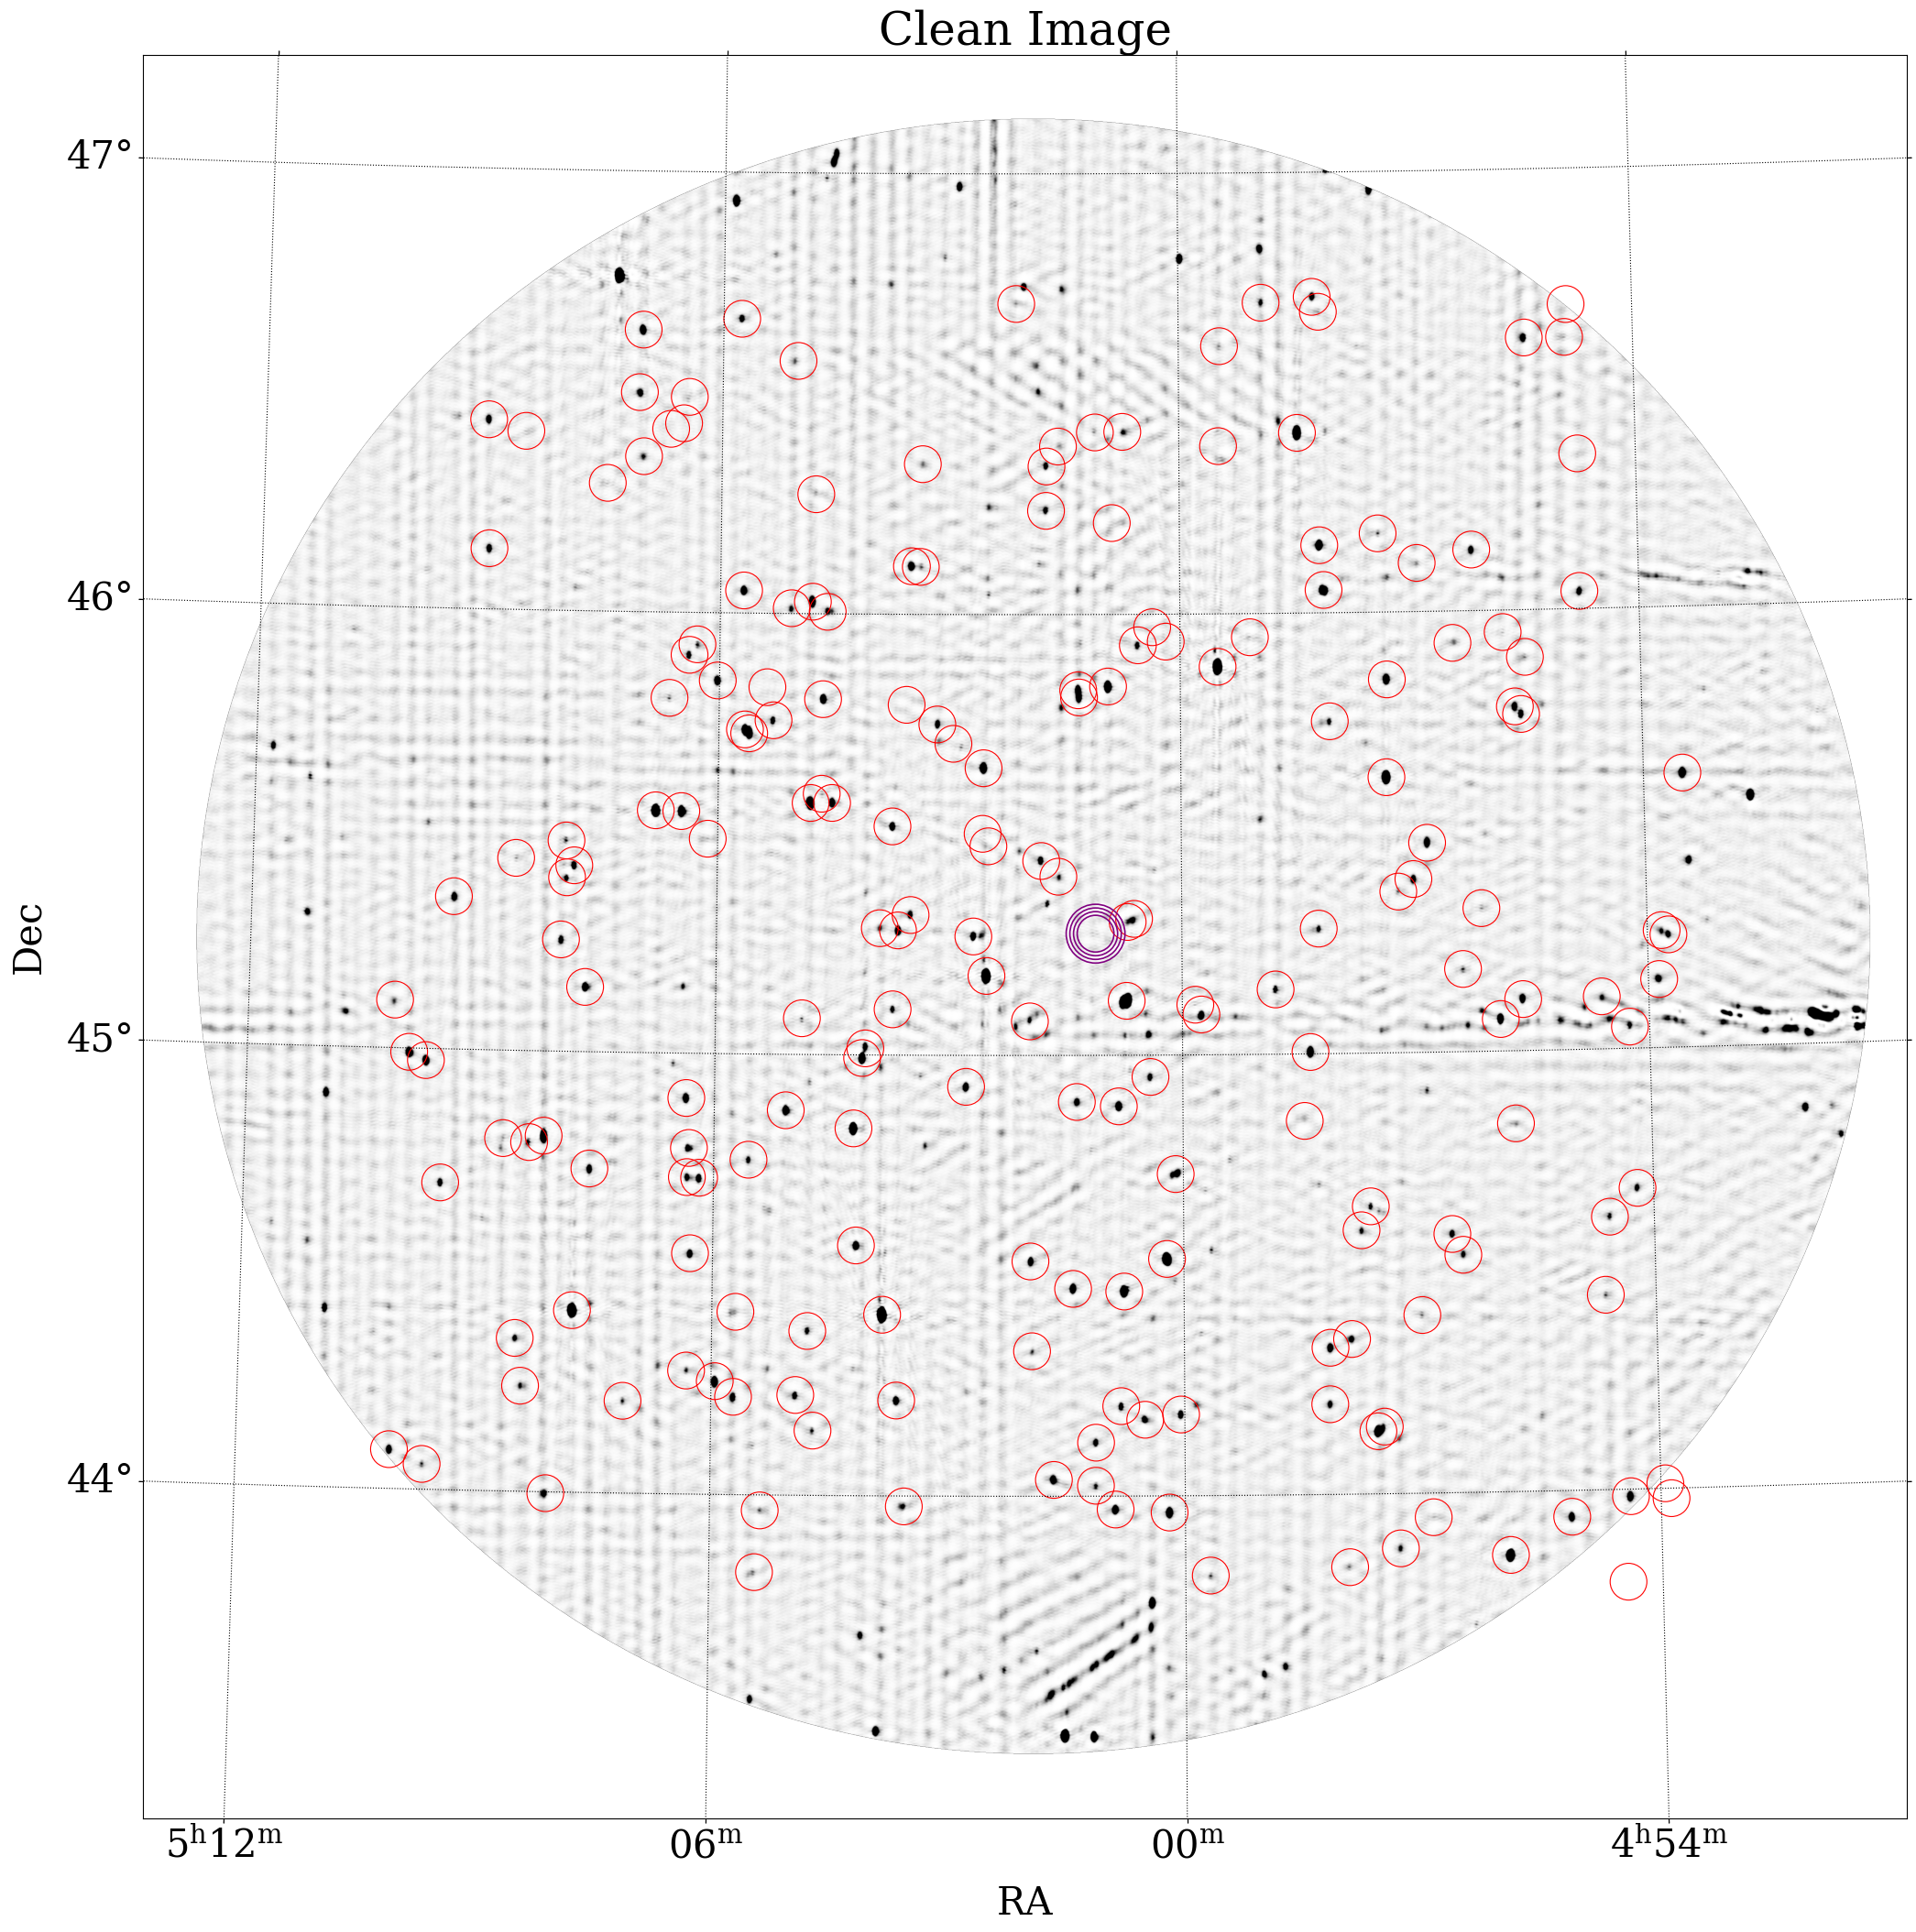

In [35]:
print(f'Saving clean image {os.path.join(basepath, imagename)}...')
print('\n')

from astropy.wcs.utils import skycoord_to_pixel

if os.path.exists(os.path.join(basepath, imagename) + '.image.fits'):
    os.remove(os.path.join(basepath, imagename) + '.image.fits')
exportfits(os.path.join(basepath, imagename) + '.image', os.path.join(basepath, imagename) + '.image.fits')

# Load the FITS image
fits_file = os.path.join(basepath, imagename) + '.image.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (25, 25))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

# Define the sky coordinate for the magnetar (J2000 is equivalent to ICRS)
mag_coord = SkyCoord('05:01:06.76', '+45:16:33.92', unit=(u.hourangle, u.deg), frame='icrs')
# Convert the sky coordinate to pixel coordinates using your 2D WCS
x_mag, y_mag = skycoord_to_pixel(mag_coord, wcs_2d)
circle_mag_1 = Circle((x_mag, y_mag), radius=50, edgecolor='purple', facecolor='none', lw=1.2, transform=ax.get_transform('pixel'))
ax.add_patch(circle_mag_1)
circle_mag_2 = Circle((x_mag, y_mag), radius=60, edgecolor='purple', facecolor='none', lw=1.2, transform=ax.get_transform('pixel'))
ax.add_patch(circle_mag_2)
circle_mag_3 = Circle((x_mag, y_mag), radius=70, edgecolor='purple', facecolor='none', lw=1.2, transform=ax.get_transform('pixel'))
ax.add_patch(circle_mag_3)
circle_mag_4 = Circle((x_mag, y_mag), radius=80, edgecolor='purple', facecolor='none', lw=1.2, transform=ax.get_transform('pixel'))
ax.add_patch(circle_mag_4)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Clean Image')
plt.grid(color='k', ls='dotted')
fig.savefig(os.path.join(basepath, f'{imagename}.image.pdf'))
plt.show()

In [37]:
print(x_mag, y_mag)
print(hdu.data[0, 0, :, :].shape)

2591.127005377693 2407.6125690784206
(4800, 4800)


In [56]:
print(f'Split off new MS file to do selfcal on so as to leave the original bandpass calibrated MS untouched...')
print('\n')

msfile_bcal_toselfcal = f'{msfile_bcal.split(".ms")[0]}_toselfcal.ms'

if os.path.exists(os.path.join(basepath, msfile_bcal_toselfcal)):
    rmtree(os.path.join(basepath, msfile_bcal_toselfcal))
    #copytree(os.path.join(basepath, msfile_image), os.path.join(basepath, msfile_image))
split(vis=os.path.join(basepath, msfile_bcal), outputvis=os.path.join(basepath, msfile_bcal_toselfcal), datacolumn='all')

Split off new MS file to do selfcal on so as to leave the original bandpass calibrated MS untouched...




In [57]:
print('Performing phase calibration...')
print('\n')

os.chdir(basepath)

#bcalfield = fieldname
pcalfield = fieldname_cal

if pcalfield is None:
    pcalfile = f'{calibrator_name}_{msdate}_allfields.pcal'
else:
    pcalfile = f'{calibrator_name}_{msdate}_f{field_cal_idx0}f{field_cal_idx1}.pcal'

if os.path.exists(os.path.join(basepath, pcalfile)):
    rmtree(os.path.join(basepath, pcalfile))

if pcalfield is None:

    gaincal(vis=os.path.join(basepath, msfile_bcal_toselfcal),
            field='',
            caltable=os.path.join(basepath, pcalfile),
            refant=refant,
            solint='inf',
            calmode='p',
            gaintype='K',
            combine='scan, obs, field',
            uvrange='>'+uvrange)

else:

    gaincal(vis=os.path.join(basepath, msfile_bcal_toselfcal),
            field=pcalfield,
            caltable=os.path.join(basepath, pcalfile),
            refant=refant,
            solint='inf',
            calmode='p',
            gaintype='K',
            combine='scan, obs, field',
            uvrange='>'+uvrange)

Performing phase calibration...




In [58]:
print('Applying phase solutions to non-centered MS...')
print('\n')

applycal(vis=os.path.join(basepath, msfile_bcal_toselfcal),
        field=fieldname_cal,
        gaintable=os.path.join(basepath, pcalfile))

Applying phase solutions to non-centered MS...




In [62]:
print('Splitting off corrected data from cleaned, bandpass calibrated image...')
print('\n')

msfile_bcal_selfcal = f'{msfile_bcal.split(".ms")[0]}_selfcal.ms'

split(vis=os.path.join(basepath, msfile_bcal_toselfcal),
      outputvis=os.path.join(basepath, msfile_bcal_selfcal),
      datacolumn='all')

Splitting off corrected data from cleaned, bandpass calibrated image...




In [63]:
print('\n')
print('Second round imaging with tclean...')
print('\n')

os.chdir(basepath)

imsize_x, imsize_y = 4800, 4800
cell_res = '3arcsec'
weighttype = 'briggs'
niter = 10000
weight = 0.5
uvrange = '1klambda'
imagetype = 'clean'
imageparams = f'{imagetype}_{weighttype}{weight}_uv{uvrange}_{imsize_x}x{cell_res[:4]}_nitr{niter}'
imagename_selfcal = f'{msfile_bcal.split(".ms")[0]}_f{field_cal_idx0}f{field_cal_idx1}_{imageparams}_selfcal'
tclean(vis=os.path.join(basepath, msfile_bcal_selfcal),
    field=fieldname_cal,            
    imagename=os.path.join(basepath, imagename_selfcal),
    specmode='mfs',
    deconvolver='hogbom',
    gridder='wproject',
    wprojplanes=-1,  # auto (if using wproject)
    niter=niter,             
    threshold='0.005Jy',
    interactive=False,
    imsize=[imsize_x, imsize_y],
    cell=[cell_res], 
    weighting=weighttype,
    robust=weight,
    pblimit=0.25,
    psfcutoff=0.5,
    uvrange='>'+uvrange,
    phasecenter=phasecenter,
    savemodel='modelcolumn')



Second round imaging with tclean...




2025-03-10 06:38:52	WARN	task_tclean::WProjectFT::getImage	No useful data in WProjectFT: weights all zero
2025-03-10 06:38:53	WARN	task_tclean::SIImageStore::getPSFGaussian (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2075)	PSF is blank for[C0:P0] 
2025-03-10 06:39:08	WARN	task_tclean::WProjectFT::getImage	No useful data in WProjectFT: weights all zero
2025-03-10 06:39:11	WARN	SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2284)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 10000,
 'cyclethreshold': 0.0,
 'interactiveiterdone': 0,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 0,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.0,
 'minpsffraction': 0.05000000074505806,
 'niter': 10000,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 2,
 'summarymajor': array([0]),
 'summaryminor': {0: {}},
 'threshold': 0.0,
 'stopDescription': 'threshold'}

Saving self-cleaned image...




Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


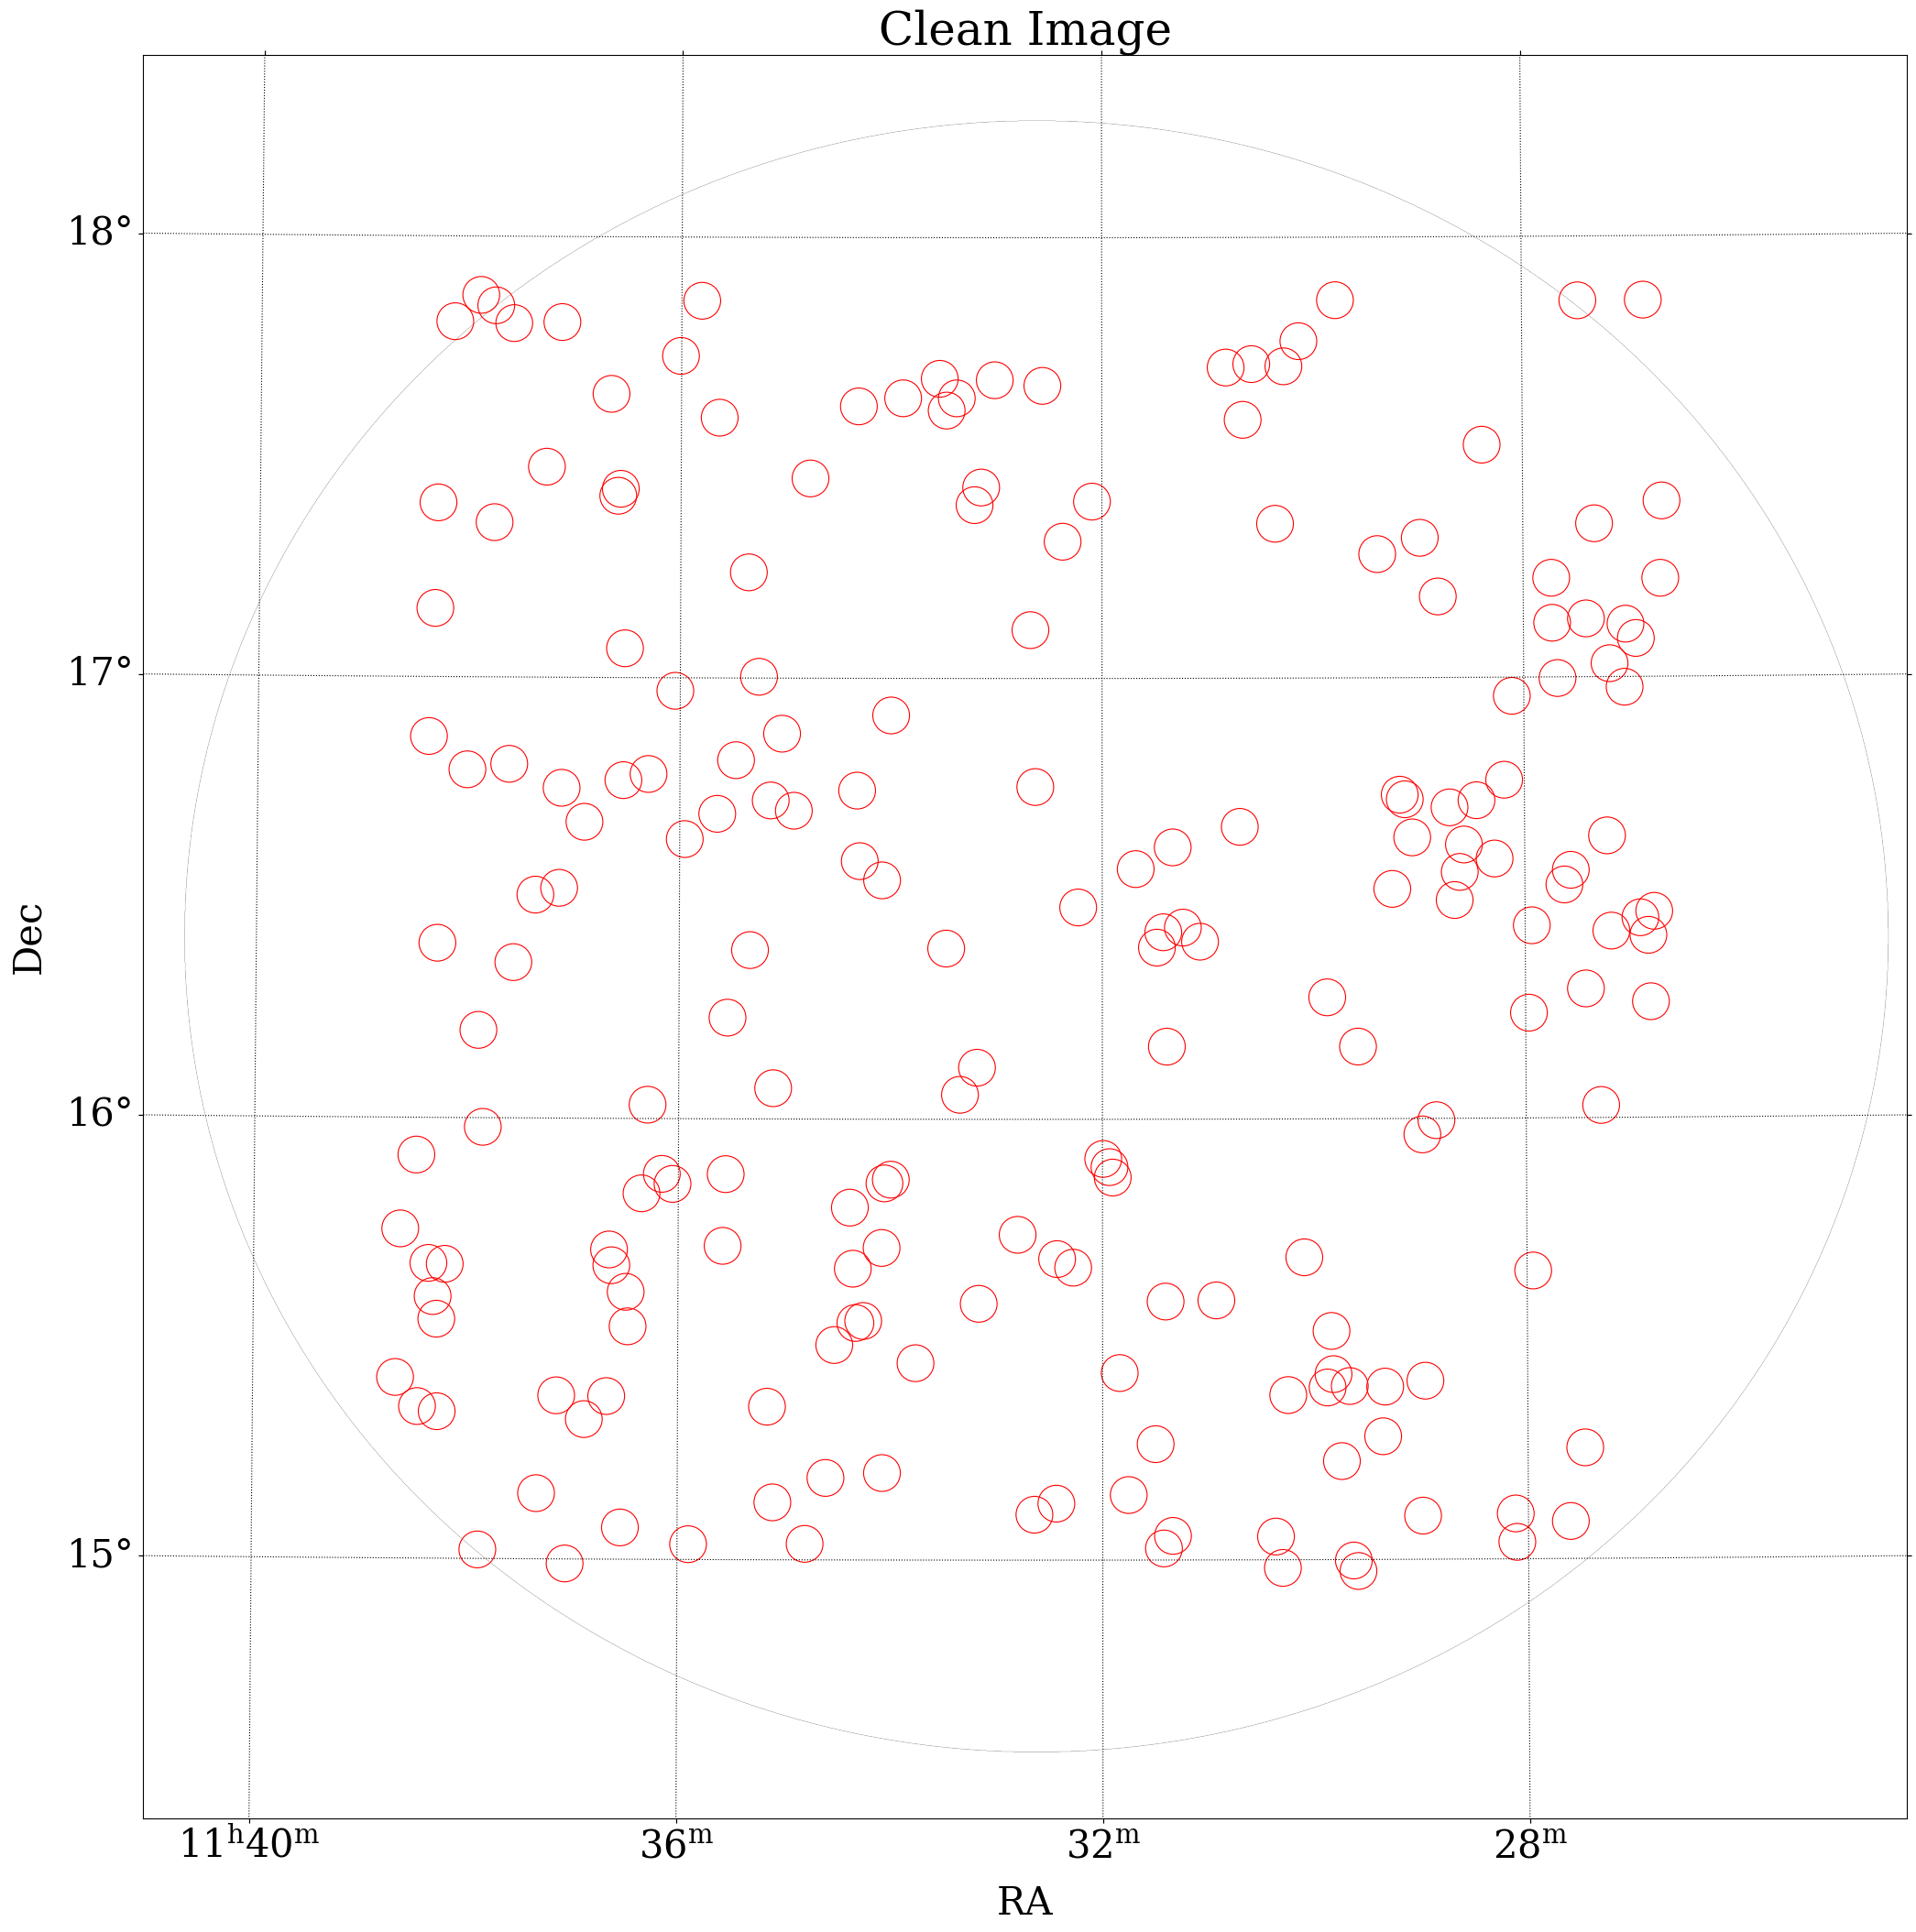

In [61]:
print('Saving self-cleaned image...')
print('\n')
if os.path.exists(os.path.join(basepath, imagename_selfcal) + '.image.fits'):
    os.remove(os.path.join(basepath, imagename_selfcal) + '.image.fits')
exportfits(os.path.join(basepath, imagename_selfcal) + '.image', os.path.join(basepath, imagename_selfcal) + '.image.fits')

# Load the FITS image
fits_file = os.path.join(basepath, imagename_selfcal) + '.image.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (25, 25))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

# Overlay circles around NVSS sources on the FITS image
for xi, yi in zip(wcs_2d_coords_x, wcs_2d_coords_y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Clean Image')
plt.grid(color='k', ls='dotted')
fig.savefig(os.path.join(basepath, f'{imagename_selfcal}.image.pdf'))